In [1]:
# load some libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import integrate
from scipy.special import sph_harm
from scipy.special import erf
import hf_routines as hf
import plotting as myplt

In [2]:
# setup the system
N = 6        # number of electrons
nAtoms = 2   # number of atoms
M = 4        # number of basis functions

In [3]:
# set STO-3G basis 
d1s = [0.15432897,0.53532814,0.44463454]
d2s = [-0.09996723,0.39951283,0.70011547]
alpha1s = [16.1195750,2.9362007,0.7946505]
alpha2s = [0.6362897,0.1478601,0.0480887]
R = np.empty((nAtoms,3),dtype=float)
R[0,0] = R[0,1] = R[0,2] = 0.0
R[1,0] = 1.5
R[1,1] = R[1,2] = 0.0
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
alpha_basis = np.stack((alpha1s,alpha2s,alpha1s,alpha2s))
d_basis = np.stack((d1s,d2s,d1s,d2s))
Z = [3.0,3.0]
basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]

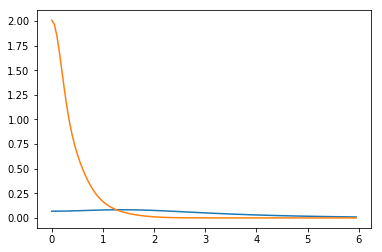

In [4]:
r = np.arange(0,6,0.05)
plt.plot(r,basis_set[1].sto_ng(r))
plt.plot(r,basis_set[0].sto_ng(r))

In [4]:
S, Sinv = hf.overlap(basis_set)
print(S)

[[ 1.          0.24113665  0.18502059  0.2334712 ]
 [ 0.24113665  1.          0.2334712   0.92757185]
 [ 0.18502059  0.2334712   1.          0.24113665]
 [ 0.2334712   0.92757185  0.24113665  1.        ]]


In [5]:
X = hf.orthogonalize_basis(S)
print X

[[ 0.21083317  0.65087864  0.78319061  0.02713379]
 [ 0.43261039 -0.31720645  0.00808411 -2.62872712]
 [ 0.21083317  0.65087864 -0.78319061 -0.02713379]
 [ 0.43261039 -0.31720645 -0.00808411  2.62872712]]


In [6]:
# compute matrices and twoE that are not dependent on coefficients
T = hf.kinetic(basis_set)
V = hf.core_potential(basis_set,atoms)
Hcore = V + T
print Hcore

[[-6.40310428 -1.44897037 -1.46209339 -1.41989902]
 [-1.44897037 -2.22862415 -1.41989902 -2.12065697]
 [-1.46209339 -1.41989902 -6.40310428 -1.44897037]
 [-1.41989902 -2.12065697 -1.44897037 -2.22862415]]


In [7]:
twoE = hf.compute_twoE(basis_set)
print twoE

[[[[ 1.68039515  0.26542036  0.2023697   0.26986305]
   [ 0.26542036  0.39772686  0.15015659  0.36263087]
   [ 0.2023697   0.15015659  0.66051015  0.15113066]
   [ 0.26986305  0.36263087  0.15113066  0.36898177]]

  [[ 0.26542036  0.04994146  0.03851446  0.04979142]
   [ 0.04994146  0.09286014  0.03379539  0.08443977]
   [ 0.03851446  0.03379539  0.15113066  0.03400807]
   [ 0.04979142  0.08443977  0.03400807  0.08595958]]

  [[ 0.2023697   0.03851446  0.04024162  0.03879839]
   [ 0.03851446  0.07158965  0.03879839  0.06782388]
   [ 0.04024162  0.03879839  0.2023697   0.03851446]
   [ 0.03879839  0.06782388  0.03851446  0.07158965]]

  [[ 0.26986305  0.04979142  0.03879839  0.04980084]
   [ 0.04979142  0.09025963  0.03358599  0.08238896]
   [ 0.03879839  0.03358599  0.15015659  0.03379539]
   [ 0.04980084  0.08238896  0.03379539  0.0841151 ]]]


 [[[ 0.26542036  0.04994146  0.03851446  0.04979142]
   [ 0.04994146  0.09286014  0.03379539  0.08443977]
   [ 0.03851446  0.03379539  0.15113

In [8]:
def perform_hf_scf(basis_set,atoms,C,iteration):
    S, Sinv = hf.overlap(basis_set)
    # compute matrices and twoE that are not dependent on coefficients
    T = hf.kinetic(basis_set)
    V = hf.core_potential(basis_set,atoms)
    Hcore = V + T
    twoE = hf.compute_twoE(basis_set)
    # orthogonalize basis
    X = hf.orthogonalize_basis(S)
    if iteration==0:
        # make Hcore guess
        HcoreX = np.dot(np.dot(X.T,Hcore),X)
        e, C = np.linalg.eig(HcoreX)
        C = np.dot(X,C)
    # perform SCF
    previousE = 0.0
    deltaE = 1.0
    thresh = 0.00001
    iteration = 0 
    while deltaE > thresh and iteration < 20:
        P = hf.constructDensityMat(C,N)
        G = hf.compute_G(P,twoE)
        F = Hcore + G
        energy, C, orbitalEnergies = hf.total_energy(F,X,Hcore,P,atoms,N)
        deltaE = abs(energy-previousE)
        previousE = energy
        iteration += 1
        #print iteration, energy, deltaE
    hf_twoE = hf.update_twoE(C,twoE)
    return energy, C, Hcore, F, hf_twoE

In [9]:
R[1,0] = 1.5
C = np.empty((M,M))
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
hf_energy_15, C, Hcore,F,hf_twoE = perform_hf_scf(basis_set,atoms,C,0)
print hf_energy_15

-14.105531508675007


In [31]:
r = np.arange(0.5,10,0.01)
hf_energy = np.empty(r.size)
C = np.empty((M,M))
for j in range(r.size):
    R[1,0] = r[j]
    R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
    basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
    atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
    hf_energy[j], C, Hcore, F, hf_twoE = perform_hf_scf(basis_set,atoms,C,j)
    #print r[j],hf_energy[j]

KeyboardInterrupt: 

In [32]:
np.savetxt("li2_rhf_mycode.txt",np.column_stack((r,hf_energy)))

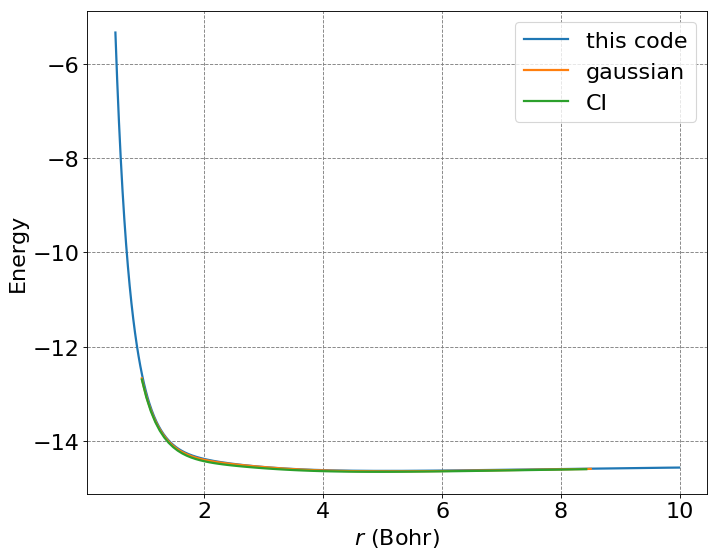

In [24]:
# plot
gauss_rhf = np.loadtxt("li2_rhf.txt",skiprows=1)
gauss_cas = np.loadtxt("li2_cas.txt",skiprows=1)
ax = myplt.define_figure(xlabel="$r$ (Bohr)",ylabel="Energy")
#ax.set_ylim(-15,10)
ax.plot(r,hf_energy,lw=2,label="this code")
ax.plot(gauss_rhf[:,0]*1.889725989,gauss_rhf[:,1],lw=2,label="gaussian")
ax.plot(gauss_cas[:,0]*1.889725989,gauss_cas[:,1],lw=2,label="CI")
ax.legend(fontsize=20)

In [12]:
print(r[np.argmin(hf_energy)])
print(np.amin(hf_energy))

NameError: name 'hf_energy' is not defined

In [6]:
R[1,0] = 5.04
C = np.empty((M,M))
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
basis_set = [hf.sto(3,d_basis[i],alpha_basis[i],R_basis[i,:]) for i in range(M)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
hfE, C, oribtalEnergies = perform_hf_scf(basis_set,atoms,C,0)
print oribtalEnergies

[-2.35085604 -2.35057445 -0.1574185   0.09063552]


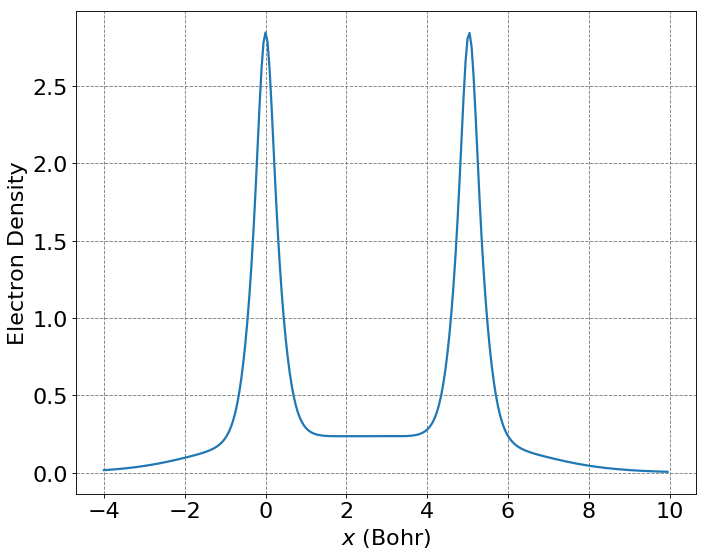

In [7]:
# plot electron density
x = np.arange(-4,10,0.05)
P = hf.constructDensityMat(C,N)
density1 = hf.compute_electron_density(basis_set,P,x)
#density2 = hf.compute_electron_density(basis_set,P_z_1_2,x)
ax = myplt.define_figure(xlabel="$x$ (Bohr)",ylabel="Electron Density")
ax.plot(x,density1,lw=2)
#ax.plot(x,density2,lw=2,label="Z=2")
ax.legend(fontsize=20)

In [5]:
# set STO-3G basis 
alpha1s = [0.15432897,0.53532814,0.44463454]
alpha2s = [-0.09996723,0.39951283,0.70011547]
d1s = [16.1195750,2.9362007,0.7946505]
d2s = [0.6362897,0.1478601,0.0480887]
R = np.empty((nAtoms,3),dtype=float)
R[0,0] = R[0,1] = R[0,2] = 0.0
R[1,0] = 1.5
R[1,1] = R[1,2] = 0.0
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
alpha_basis = np.stack((alpha1s,alpha2s,alpha1s,alpha2s))
d_basis = np.stack((d1s,d2s,d1s,d2s))
Z = [1.0,1.0]
basis_set = [hf.sto(3,d_basis[i],alpha_basis[i],R_basis[i,:]) for i in range(2)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]

In [6]:
S, Sinv = hf.overlap(basis_set)
X = hf.orthogonalize_basis(S)
print X.T

[[-0.81171434  0.81171432]
 [-0.63470979 -0.6347098 ]]


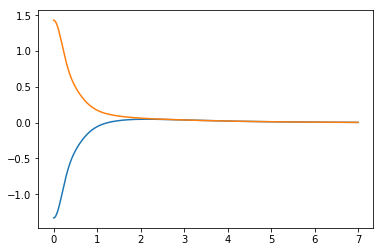

In [7]:
r = np.arange(0,7,0.01)
plt.plot(r,-0.68812269*basis_set[0].sto_ng(r)+0.72775407*basis_set[1].sto_ng(r))
plt.plot(r,0.68812269*basis_set[0].sto_ng(r)+0.72775407*basis_set[1].sto_ng(r))

## CI

In [10]:
# create and populate density matrix
def constructDensityMatCI(C,N):
    M = C.shape[0]
    P = np.zeros((M,M),dtype=float)
    occupied_orbitals = [0,1,3]
    for i in range(M):
        for j in range(i,M):
            for a in occupied_orbitals:
                P[i,j] += C[i,a]*C[j,a]
            P[i,j] *= 2.0
            P[j,i] = P[i,j]
    return P

In [11]:
# compute total energy for HF
def electronic_energy(F,Hcore,P):
    Etotal = 0.0
    for i in range(M):
        for j in range(M):
            Etotal += P[i,j]*(Hcore[i,j]+F[i,j])
    Etotal*=0.5
    return Etotal

In [12]:
def li2_ci(C,F,Hcore,twoE,atoms):
    
    P_gs = hf.constructDensityMat(C,N)
    P_es = constructDensityMatCI(C,N)
    
    HCI = np.empty((2,2))
    HCI[0,0] = electronic_energy(F,Hcore,P_gs)
    HCI[1,1] = electronic_energy(F,Hcore,P_es)
    HCI[0,1] = HCI[1,0] = twoE[2,3,3,2]
    e,v = np.linalg.eig(HCI)
    idx = e.argsort()
    e = e[idx]
    v = v[:,idx]
    # nuclear energy
    Enucl = 0.0
    nAtoms = len(atoms)
    for atom1 in range(nAtoms-1):
        for atom2 in range(atom1+1,nAtoms):
            diff = atoms[atom1].pos - atoms[atom2].pos
            dist = np.linalg.norm(diff)
            Enucl += atoms[atom1].charge*atoms[atom2].charge/dist
    e += Enucl
    return e, v


In [13]:
r = np.arange(1.0,40,0.1)
hf_energy = np.empty(r.size)
ci_energy = np.empty(r.size)
C = np.empty((M,M))
for j in range(r.size):
    R[1,0] = r[j]
    R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
    basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
    atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
    if r[j] < 12.5:
        hf_energy[j], C, F, Hcore, hf_twoE = perform_hf_scf(basis_set,atoms,C,j)
    else:
        hf_energy[j], C, F, Hcore, hf_twoE = perform_hf_scf(basis_set,atoms,C,0)
    ci_energies, ci_vecs = li2_ci(C,F,Hcore,hf_twoE,atoms)
    ci_energy[j] = ci_energies[0]

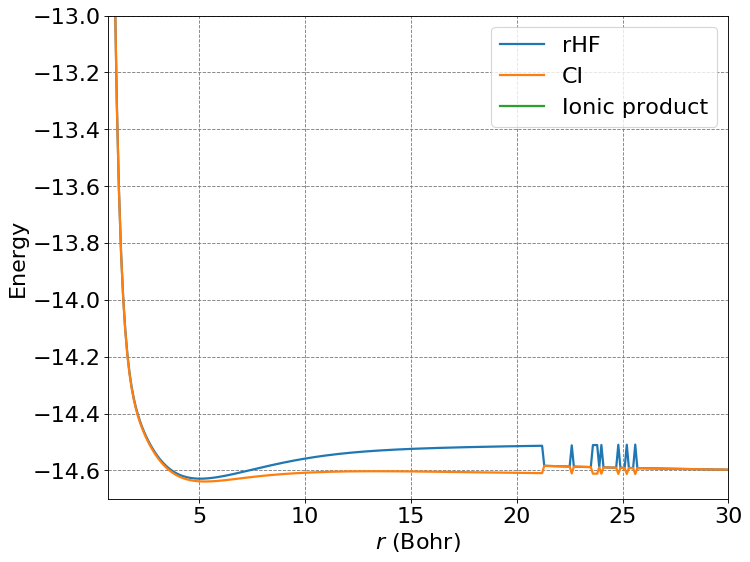

In [14]:
ax = myplt.define_figure(xlabel="$r$ (Bohr)",ylabel="Energy")
#ax.set_ylim(-15,10)
ax.plot(r,hf_energy,lw=2,label="rHF")
ax.plot(r,ci_energy,lw=2,label="CI")
ax.plot(r,-1.0/r,lw=2,label="Ionic product")
ax.set_xlim(0.7,30)
ax.set_ylim(-14.7,-13)
ax.legend(fontsize=20)

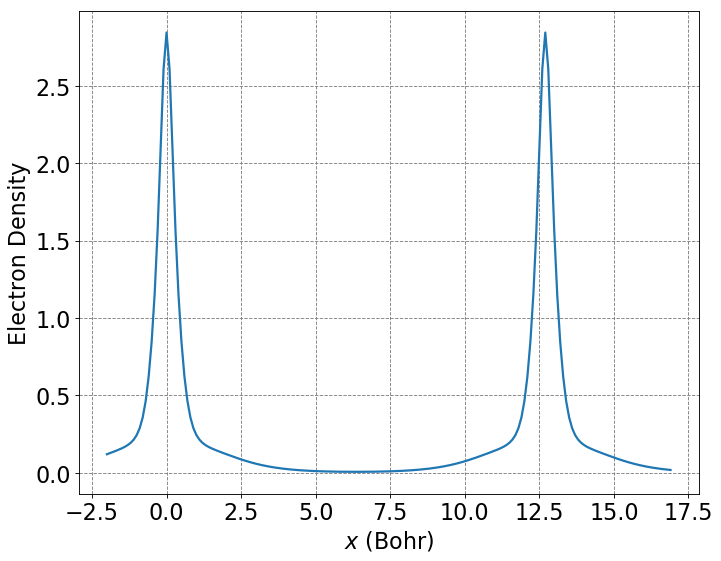

In [44]:
R[1,0] = 12.7
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
hf_energy[j], C, F, Hcore, hf_twoE = perform_hf_scf(basis_set,atoms,C,0)
ci_energies, ci_vecs = li2_ci(C,F,Hcore,hf_twoE,atoms)
x = np.arange(-2,17,0.1)
P = hf.constructDensityMat(C,N)
hf_density = hf.compute_electron_density(basis_set,P,x)
ax = myplt.define_figure(xlabel="$x$ (Bohr)",ylabel="Electron Density")
ax.plot(x,hf_density,lw=2,label="rHF r=12.7")

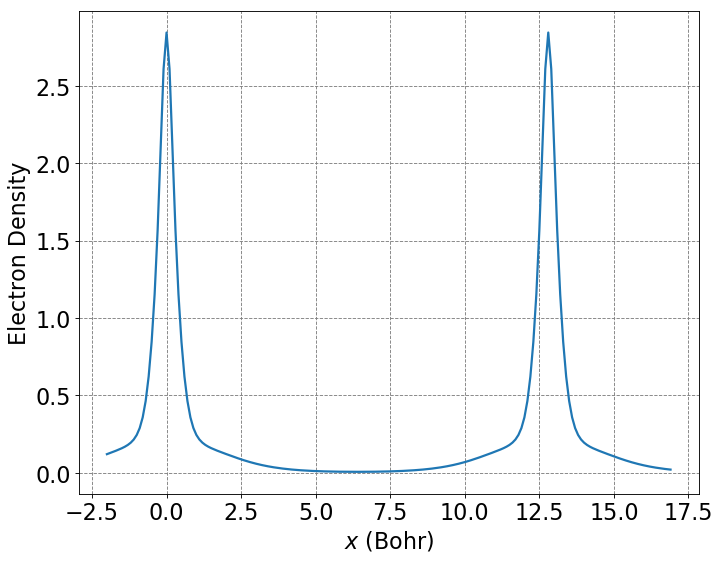

In [39]:
R[1,0] = 12.8
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
hfE, C, F, Hcore, hf_twoE = perform_hf_scf(basis_set,atoms,C,0)
ci_energies, ci_vecs = li2_ci(C,F,Hcore,hf_twoE,atoms)
x = np.arange(-2,17,0.1)
P = hf.constructDensityMat(C,N)
hf_density = hf.compute_electron_density(basis_set,P,x)
ax = myplt.define_figure(xlabel="$x$ (Bohr)",ylabel="Electron Density")
ax.plot(x,hf_density,lw=2,label="rHF r=12.8")

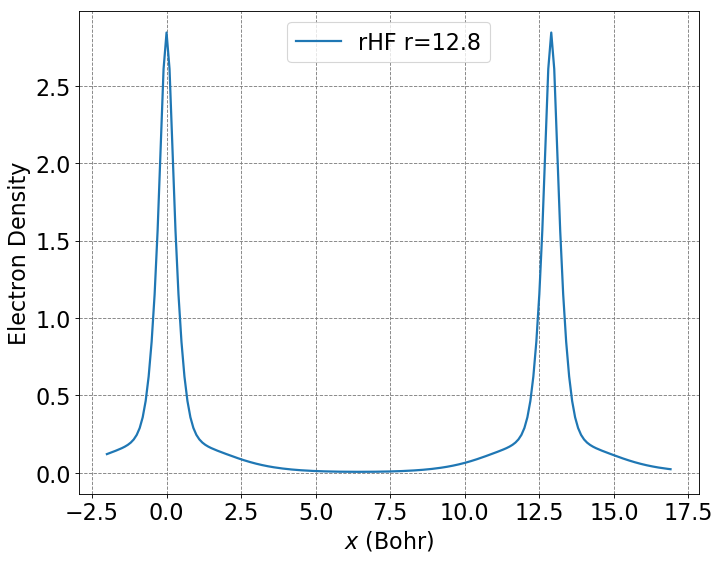

In [45]:
R[1,0] = 12.9
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
hfE, C, F, Hcore, hf_twoE = perform_hf_scf(basis_set,atoms,C,0)
ci_energies, ci_vecs = li2_ci(C,F,Hcore,hf_twoE,atoms)
x = np.arange(-2,17,0.1)
P = hf.constructDensityMat(C,N)
hf_density = hf.compute_electron_density(basis_set,P,x)
ax = myplt.define_figure(xlabel="$x$ (Bohr)",ylabel="Electron Density")
ax.plot(x,hf_density,lw=2,label="rHF r=12.8")
plt.legend(fontsize=20)

[[ 0.7012993  -0.70144517 -0.19590911 -0.19881098]
 [ 0.02270257 -0.0220899   0.7223261   0.73434872]
 [-0.70129736 -0.7014471  -0.19590911  0.19881098]
 [-0.02270251 -0.02208997  0.7223261  -0.73434872]]
[[ 0.70130033  0.70144389 -0.19598959  0.19872805]
 [ 0.02268499  0.02210825  0.72268053 -0.73397679]
 [-0.70130435  0.70143988 -0.19598959 -0.19872805]
 [-0.02268511  0.02210812  0.72268053  0.73397679]]
[[ 0.70130506  0.70143885 -0.19606655  0.19864926]
 [ 0.02266858  0.02212569  0.72301624 -0.73362551]
 [-0.70130717  0.70143674 -0.19606655 -0.19864926]
 [-0.02266865  0.02212562  0.72301624  0.73362551]]
[[ 0.7013142  -0.70142934 -0.19614008 -0.19857445]
 [ 0.02265334 -0.02214221  0.72333405  0.73329388]
 [-0.70130515 -0.70143839 -0.19614008  0.19857445]
 [-0.02265306 -0.0221425   0.72333405 -0.73329388]]
[[ 0.70131261  0.70143067 -0.19621002  0.19850308]
 [ 0.02263831  0.02215808  0.72363474 -0.73298094]
 [-0.70131366  0.70142963 -0.19621002 -0.19850308]
 [-0.02263834  0.02215805  

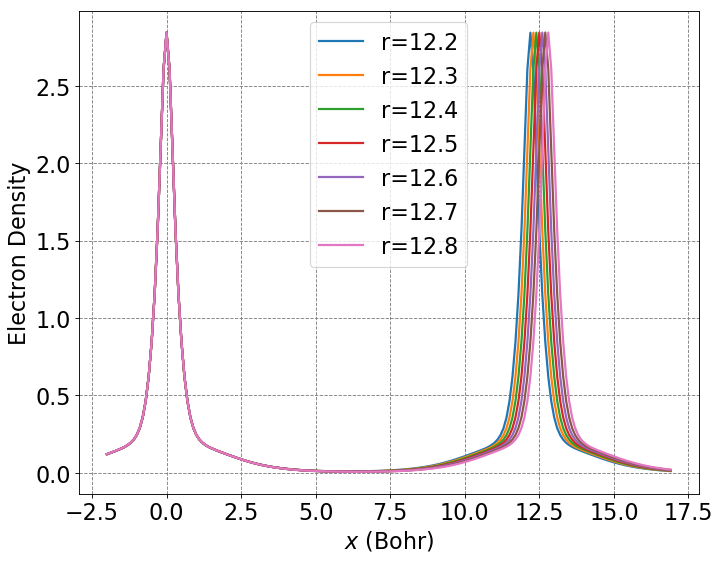

In [38]:
R[1,0] = 12.2
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
hfE, C, F, Hcore, hf_twoE = perform_hf_scf(basis_set,atoms,C,0)
ci_energies, ci_vecs = li2_ci(C,F,Hcore,hf_twoE,atoms)
x = np.arange(-2,17,0.1)
P = hf.constructDensityMat(C,N)
print C
hf_density_12_2 = hf.compute_electron_density(basis_set,P,x)
R[1,0] = 12.3
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
hfE, C, F, Hcore, hf_twoE = perform_hf_scf(basis_set,atoms,C,0)
ci_energies, ci_vecs = li2_ci(C,F,Hcore,hf_twoE,atoms)
P = hf.constructDensityMat(C,N)
print C
hf_density_12_3 = hf.compute_electron_density(basis_set,P,x)
R[1,0] = 12.4
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
hfE, C, F, Hcore, hf_twoE = perform_hf_scf(basis_set,atoms,C,0)
ci_energies, ci_vecs = li2_ci(C,F,Hcore,hf_twoE,atoms)
P = hf.constructDensityMat(C,N)
print C
hf_density_12_4 = hf.compute_electron_density(basis_set,P,x)
R[1,0] = 12.5
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
hfE, C, F, Hcore, hf_twoE = perform_hf_scf(basis_set,atoms,C,j)
ci_energies, ci_vecs = li2_ci(C,F,Hcore,hf_twoE,atoms)
P = hf.constructDensityMat(C,N)
print C
hf_density_12_5 = hf.compute_electron_density(basis_set,P,x)
R[1,0] = 12.6
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
hfE, C, F, Hcore, hf_twoE = perform_hf_scf(basis_set,atoms,C,0)
ci_energies, ci_vecs = li2_ci(C,F,Hcore,hf_twoE,atoms)
P = hf.constructDensityMat(C,N)
print C
hf_density_12_6 = hf.compute_electron_density(basis_set,P,x)
R[1,0] = 12.7
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
hfE, C, F, Hcore, hf_twoE = perform_hf_scf(basis_set,atoms,C,0)
ci_energies, ci_vecs = li2_ci(C,F,Hcore,hf_twoE,atoms)
P = hf.constructDensityMat(C,N)
print C
hf_density_12_7 = hf.compute_electron_density(basis_set,P,x)
R[1,0] = 12.8
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
hfE, C, F, Hcore, hf_twoE = perform_hf_scf(basis_set,atoms,C,0)
print R[1,0],hfE
ci_energies, ci_vecs = li2_ci(C,F,Hcore,hf_twoE,atoms)
P = hf.constructDensityMat(C,N)
print C
hf_density_12_8 = hf.compute_electron_density(basis_set,P,x)
ax = myplt.define_figure(xlabel="$x$ (Bohr)",ylabel="Electron Density")
ax.plot(x,hf_density_12_2,lw=2,label="r=12.2")
ax.plot(x,hf_density_12_3,lw=2,label="r=12.3")
ax.plot(x,hf_density_12_4,lw=2,label="r=12.4")
ax.plot(x,hf_density_12_5,lw=2,label="r=12.5")
ax.plot(x,hf_density_12_6,lw=2,label="r=12.6")
ax.plot(x,hf_density_12_7,lw=2,label="r=12.7")
ax.plot(x,hf_density_12_8,lw=2,label="r=12.8")
plt.legend(fontsize=20)

[[ 0.70078642 -0.70148389  0.19307256  0.21053321]
 [ 0.02827716 -0.01948344 -0.63119841 -0.89177273]
 [-0.70078645 -0.70148387  0.19307256 -0.21053321]
 [-0.02827716 -0.01948344 -0.63119841  0.89177273]]


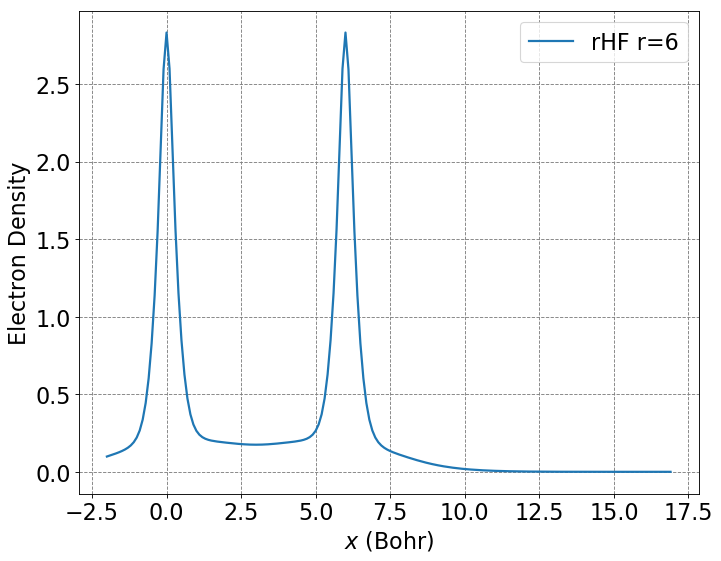

In [23]:
C = np.empty((M,M))
R[1,0] = 6
R_basis = np.stack((R[0,:],R[0,:],R[1,:],R[1,:]))
basis_set = [hf.sto(3,alpha_basis[i],d_basis[i],R_basis[i,:]) for i in range(M)]
atoms = [hf.atom(R[i,:],Z[i]) for i in range(nAtoms)]
hfE, C, F, Hcore, hf_twoE = perform_hf_scf(basis_set,atoms,C,0)
ci_energies, ci_vecs = li2_ci(C,F,Hcore,hf_twoE,atoms)
x = np.arange(-2,17,0.1)
P = hf.constructDensityMat(C,N)
print C
hf_density = hf.compute_electron_density(basis_set,P,x)
ax = myplt.define_figure(xlabel="$x$ (Bohr)",ylabel="Electron Density")
ax.plot(x,hf_density,lw=2,label="rHF r=6")
plt.legend(fontsize=20)